# 2D pattern matching
Jakub Karbowski

## Streszczenie

Zaimplementowano algorytm Aho-Corasick
do szukania wielu wzorców w tekście.
Za jego pomocą wyszukiwane są wzorce 2D,
szukając najpierw kolumn, a potem
dopasowanych kolumn w wierszach.

Działa wyszukiwanie wielu wzorców 2D
jednym automatem.

Wyszukiwanie w tekście działa dobrze.

Wyszukiwanie w zdjęciach działa dobrze.

## Trie

In [1]:
struct TrieNode{T}
    parent::Int
    char::Union{Missing, T}
    children::Dict{T, Int}
end

struct Trie{T}
    nodes::Vector{TrieNode{T}}
end

Trie(::Type{T}) where T = Trie{T}(TrieNode{T}[TrieNode{T}(0, missing, Dict{T, Int}())])

function Base.push!(trie::Trie{T}, text::Vector{T}) where T
    node::Int = 1
    for c = text
        if !haskey(trie.nodes[node].children, c)
            newnode = TrieNode{T}(node, c, Dict{T, Int}())
            push!(trie.nodes, newnode)
            trie.nodes[node].children[c] = length(trie.nodes)
        end
        node = trie.nodes[node].children[c]
    end
    trie
end

## Automata

In [2]:
struct SMA{T}
    states::UnitRange{Int64}
    delta::Dict{Tuple{Int, T}, Int}
    init::Int
    term::Set{Int}
end

## Single pattern matching
Aho-Corasick

In [3]:
buildsma(pat::String, A::String) = buildsma(collect(pat), collect(A))

function buildsma(pat::Vector{T}, A::Vector{T}) where T
    states = 0
    function newstate()
        s = states
        states += 1
        s
    end
    
    terminal = newstate()
    
    delta = Dict{Tuple{Int, T}, Int}()
    for b = A
        delta[0, b] = 0
    end
    
    for a = pat
        temp = delta[terminal, a]
        x = newstate()
        delta[terminal, a] = x
        for b = A
            delta[x, b] = delta[temp, b]
        end
        terminal = x
    end
    SMA{T}(0:terminal, delta, 0, Set{Int}([terminal]))
end

buildsma (generic function with 2 methods)

## Multi pattern matching
Aho-Corasick with trie

In [4]:
buildsma(pats::Vector{String}, A::String) = buildsma(collect.(pats), collect(A))

function buildsma(pats::Vector{Vector{T}}, A::Vector{T}) where T
    trie = Trie(T)
    for pat = pats
        push!(trie, pat)
    end
    
    term = Set{Int}()
    
    if isempty(trie.nodes[1].children)
        push!(term, 1)
    end
    
    delta = Dict{Tuple{Int, T}, Int}()
    
    for b = A
        delta[1, b] = 1
    end
    
    queue = Int[]
    
    for node = values(trie.nodes[1].children)
        push!(queue, node)
    end
    
    while !isempty(queue)
        x = popfirst!(queue)
        for child = values(trie.nodes[x].children)
            push!(queue, child)
        end
        
        t = trie.nodes[x].parent
        a = trie.nodes[x].char
        
        temp = delta[t, a]
        delta[t, a] = x
        
        if isempty(trie.nodes[x].children) || isempty(trie.nodes[temp].children)
            push!(term, x)
        end
        
        for b = A
            if haskey(trie.nodes[temp].children, b)
                delta[x, b] = trie.nodes[temp].children[b]
            else
                delta[x, b] = delta[temp, b]
            end
        end
    end
    SMA{T}(1:length(trie.nodes), delta, 1, term)
end

buildsma (generic function with 4 methods)

## Universal SMA runner

In [5]:
runsma(text::String, sma::SMA{Char}) = runsma(collect(text), sma)

function runsma(text::Vector{T}, sma::SMA{T}) where T
    M = Int[]
    q = sma.init
    for i = eachindex(text)
        q = sma.delta[q, text[i]]
        if q in sma.term
            push!(M, i)
        end
    end
    M
end

runsma (generic function with 2 methods)

## Basic tests

In [6]:
automata = buildsma(["ab", "babb", "bb"], "ab")
runsma("babbb", automata)

3-element Vector{Int64}:
 3
 4
 5

In [7]:
automata = buildsma("aba", "ab")
runsma("bababa", automata)

2-element Vector{Int64}:
 4
 6

## 2D

In [8]:
find2d(text::Matrix{T}, pat::Matrix{T}) where T = find2d(text, [pat])

find2d(text::Matrix{T}, pats::Vector{Matrix{T}}) where T =
    find2drun(text, find2dbuild(pats, union(text, pats...)))

function find2dbuild(pats::Vector{Matrix{T}}, A::Vector{T}) where T
    colpats::Vector{Vector{T}} = union(eachcol.(pats)...)
    
    # column SMA
    colsma = buildsma(colpats, A)
    
    # reconstruct row pattern states
    # by running SMA on the pattern itself
    rowpats = Set{Vector{Int}}()
    for pat = pats
        rowpat = Int[]
        np, mp = size(pat)
        for col = eachcol(pat)
            q = colsma.init
            for a = col
                q = colsma.delta[q, a]
            end
            # last state in pattern column
            # is the column's accepting state
            push!(rowpat, q)
        end
        push!(rowpats, rowpat)
    end
    
    # row matching SMA
    rowsma = buildsma(collect(rowpats), collect(colsma.states))
    
    colsma, rowsma
end

function find2drun(text::Matrix{T}, (colsma, rowsma)::Tuple{SMA{T}, SMA{Int}}) where T
    n, m = size(text)
    
    # state matrix for column matching
    smat = Int[colsma.init for i = 1:n, j = 1:m]
    
    # run column SMA
    for j = 1:m
        q = colsma.init
        for i = 1:n
            q = colsma.delta[q, text[i, j]]
            smat[i, j] = q
        end
    end
    
    # run row SMA
    M = Tuple{Int, Int}[]
    for i = 1:n
        # match row
        Mr = runsma(smat[i, :], rowsma)
        for j = Mr
            push!(M, (i, j))
        end
    end
    M
end

find2drun (generic function with 1 method)

In [9]:
text = [
    'a' 'b' 'a' 'b' 'a' 'b' 'b'
    'a' 'a' 'a' 'a' 'b' 'b' 'b'
    'b' 'b' 'b' 'a' 'a' 'a' 'b'
    'a' 'a' 'a' 'b' 'b' 'a' 'a'
    'b' 'b' 'a' 'a' 'a' 'b' 'b'
    'a' 'a' 'b' 'a' 'a' 'a' 'a'
]

pat = [
    'a' 'a' 'a'
    'b' 'b' 'a'
    'a' 'a' 'b'
]

find2d(text, pat)

3-element Vector{Tuple{Int64, Int64}}:
 (4, 4)
 (5, 6)
 (6, 3)

# haystack.txt

In [11]:
lines = readlines("data/haystack.txt")
nrows = length(lines)
ncols = maximum(length.(lines))

text = [
    if j <= length(lines[i])
        lines[i][j]
    else
        '\0'
    end for i = 1:nrows, j = 1:ncols
]
;

## vertical letter repetition
SMA searches for multiple 2D vertical patterns xx,
where x is alphanumeric.

In [12]:
pats = [
    reshape([a; a], 2, 1)
    for a = '0':'z'
]

M = find2d(text, pats)

println("Found $(length(M)) matches.")
println("Here's some:")
for (i, j) = rand(M, 4)
    println("\n- Line $i, column $j:")
    print(repeat(" ", j - max(1, j - 10)))
    println("v")
    println(String(text[i-1, max(1, j-10):min(j+10, end)]))
    println(String(text[i, max(1, j-10):min(j+10, end)]))
    print(repeat(" ", j - max(1, j - 10)))
    println("^")
end

Found 235 matches.
Here's some:

- Line 30, column 24:
          v
revious pattern-match
 in order to speed u 
          ^

- Line 34, column 35:
          v
rithms involved in th
e of dictionaries or 
          ^

- Line 23, column 63:
          v
e r n . Generally we 
text of length n, whe
          ^

- Line 7, column 61:
          v
 book probably contai
r in many areas of sc
          ^


## haystack.txt - "th", "t h"

Treść trochę niejednoznaczna,
znalezłem wszystkie możliwości
osobno
a następnie wszystkie jednocześnie.

In [13]:
pat = [
    't' 'h'
    't' 'h'
]
find2d(text, pat)
# nie ma

Tuple{Int64, Int64}[]

In [14]:
pat = [
    't' ' ' 'h'
    't' ' ' 'h'
]
find2d(text, pat)
# jedno

1-element Vector{Tuple{Int64, Int64}}:
 (39, 3)

In [15]:
pat = [
    't'
    'h'
]
find2d(text, reshape(pat, length(pat), 1))
# 17

17-element Vector{Tuple{Int64, Int64}}:
 (10, 27)
 (10, 57)
 (11, 39)
 (12, 38)
 (26, 11)
 (33, 17)
 (35, 72)
 (39, 61)
 (43, 54)
 (54, 58)
 (55, 62)
 (62, 76)
 (64, 63)
 (67, 8)
 (71, 15)
 (81, 10)
 (81, 16)

In [16]:
pat = [
    't'
    ' '
    'h'
]
find2d(text, reshape(pat, length(pat), 1))
# 1

1-element Vector{Tuple{Int64, Int64}}:
 (8, 69)

In [17]:
pats = [
    [
        't' 'h'
        't' 'h'
    ],
    [
        't' ' ' 'h'
        't' ' ' 'h'
    ],
    reshape([
        't'
        'h'
    ], 2, 1),
    reshape([
        't'
        ' '
        'h'
    ], 3, 1),
]
find2d(text, pats)
# łącznie 19

19-element Vector{Tuple{Int64, Int64}}:
 (8, 69)
 (10, 27)
 (10, 57)
 (11, 39)
 (12, 38)
 (26, 11)
 (33, 17)
 (35, 72)
 (39, 3)
 (39, 61)
 (43, 54)
 (54, 58)
 (55, 62)
 (62, 76)
 (64, 63)
 (67, 8)
 (71, 15)
 (81, 10)
 (81, 16)

# haystack.png

In [19]:
import Pkg
Pkg.add("Images")
using Images

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


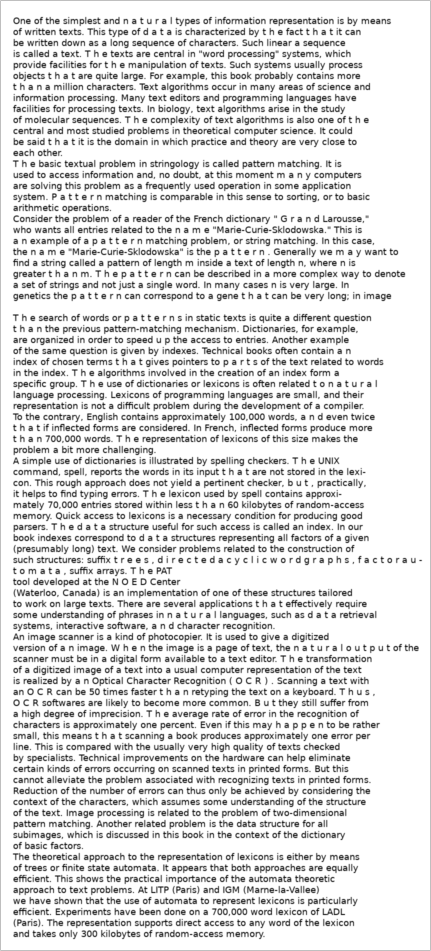

In [20]:
img = load("data/haystack.png")

## letters
Wybrałem litery 'p', 'a', 't', 'e'.
Zostały wycięte z obrazu.

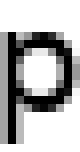

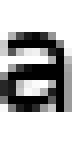

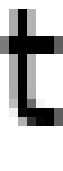

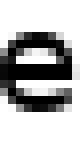

In [21]:
pats = typeof(img)[]

i, j = 474, 185
h, w = 18, 9
push!(pats, img[i:i+h, j:j+w])

i, j = 474, 202
h, w = 18, 8
push!(pats, img[i:i+h, j:j+w])

i, j = 474, 218
h, w = 18, 6
push!(pats, img[i:i+h, j:j+w])

i, j = 474, 245
h, w = 18, 9
push!(pats, img[i:i+h, j:j+w])

pats .|> display
;

Found 1550 matches.
Here's some:


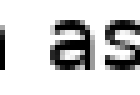

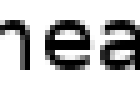

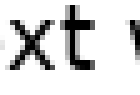

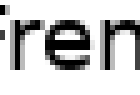

In [27]:
M = find2d(img, pats)
println("Found $(length(M)) matches.")
println("Here's some:")
for (i, j) = rand(M, 4)
    display(img[i-h:i, j-2w:j+w])
end

## "pattern"

Wycięto słowo z tekstu.

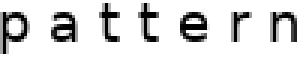

In [28]:
i, j = 474, 185
h, w = 18, 98
pat = img[i:i+h, j:j+w]

Found 5 matches:


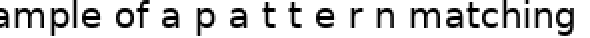

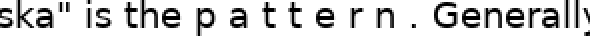

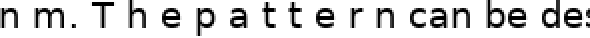

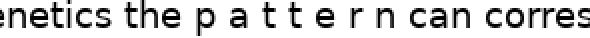

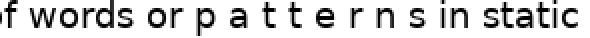

In [29]:
M = find2d(img, pat)
println("Found $(length(M)) matches:")
for (i, j) = M
    display(img[i-h:i, j-2w:j+w])
end

# Benchmark
Wyszukujemy kwadratowy wzorzec
z lewego górnego rogu obrazu.
$n$ to liczba pikseli.

In [30]:
ns = []
build_times = []
run_times = []

for n = 2:28
    pat = img[1:n, 1:n]
    pats = [pat]
    A = union(img, pat)
    sma = nothing
    bt = @elapsed (sma = find2dbuild(pats, A))
    rt = @elapsed find2drun(img, sma)
    push!(ns, n^2)
    push!(build_times, bt)
    push!(run_times, rt)
end

In [31]:
Pkg.add("Plots")
using Plots: plot

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


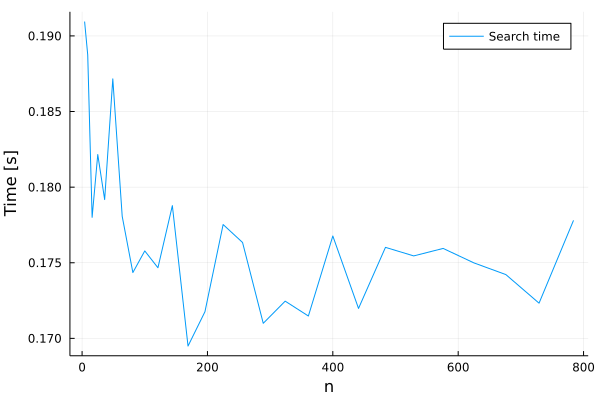

In [32]:
plot(
    ns,
    run_times,
    xlabel="n",
    ylabel="Time [s]",
    label="Search time",
)

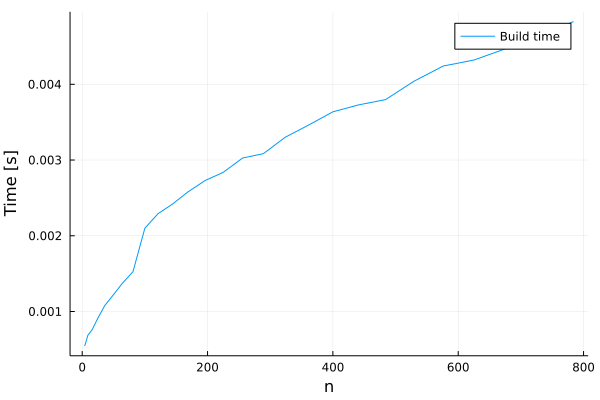

In [33]:
plot(
    ns,
    build_times,
    xlabel="n",
    ylabel="Time [s]",
    label="Build time",
)

In [34]:
i, j = 474, 185
h, w = 18, 98
pat = img[i:i+h, j:j+w]
sma = find2dbuild([pat], union(img, pat))
;

In [35]:
@elapsed find2drun(img[1:div(end, 2), :], sma)

0.134631292

In [36]:
@elapsed find2drun(img[1:div(end, 4), :], sma)

0.043936708

In [37]:
@elapsed find2drun(img[1:div(end, 8), :], sma)

0.022247209

In [38]:
@elapsed find2drun(img[:, 1:div(end, 2)], sma)

0.114949541

In [39]:
@elapsed find2drun(img[:, 1:div(end, 4)], sma)

0.044797458

In [40]:
@elapsed find2drun(img[:, 1:div(end, 8)], sma)

0.022158042

# Wnioski

Czas szukania nie zależy od wielkości wzorca,
a od wielkości tekstu zależy liniowo.

Czas budowy wydaje się zależeć liniowo od wielkości wzorca.
Zależy to od wielkości drzewa trie, które najwyraźniej
udaje się zazwyczaj optymalnie zbudować (wpływa to na liczbę stanów).